# Funnel Analysis

We are given data from a simple e-commerce site with only 4 pages that are traversed in a linear fashion.
1. **Home Page:** You can only land on the home page as a first page.
2. **Search Page:** The user can perform a search and land on the search page.
3. **Payment Page:** If the user clicks on a product, they will get to the payment page
4. **Confirmation Page:** If the user decides to buy, they end up on a confirmation page

The company CEO isn’t very happy with the company sales and, especially, sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you can create hypotheses on how conversion rate could be improved.

Specifically, she is interested in :
- A full picture of funnel conversion rate for both desktop and mobile
- Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

# Data Description
We have 5 tables. All the tables refer to only the user first experience on the site.

1. **user_table - info about the user**
 - user_id: the Id of the user. It is unique by user and can be joined to user id in all other tables
 - date: the date when the user firstly landed on the site
 - device: user device. Can be mobile or desktop
 - sex: male/female
2. **home_page_table - Users who landed on the home page**
 - user_id: the Id of the user. It is unique by user and can be joined to user id in all other tables
 - page: it is always home_page.
3. **search_page_table - Users who landed on the search_page**
 - user_id: the Id of the user. It is unique by user and can be joined to user id in all other tables
 - page: it is always search_page
4. **payment_page_table - Users who landed on the payment_page**
 - user_id: the Id of the user. It is unique by user and can be joined to user id in all other tables
 - page: it is always payment_page
5. **payment_confirmation_table - Users who landed on the payment_confirmation_table. That is, these are the users who bought the product.**
 - user_id: the Id of the user. It is unique by user and can be joined to user id in all other tables
 - page: it is always payment_confirmation_page

# Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

In [128]:
user_df = pd.read_csv('PRIVATE CSV')
print(user_df.shape)
user_df['date'] = pd.to_datetime(user_df['date'])
user_df.head()

(90400, 4)


,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [ ]:
user_df['user_id'].nunique()

90400

In [ ]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  90400 non-null  int64         
 1   date     90400 non-null  datetime64[ns]
 2   device   90400 non-null  object        
 3   sex      90400 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
user_df['device'].value_counts()

Desktop    60200
Mobile     30200
Name: device, dtype: int64

In [ ]:
user_df['sex'].value_counts()

Male      45325
Female    45075
Name: sex, dtype: int64

In [ ]:
home_df = pd.read_csv('PRIVATE CSV')
search_df = pd.read_csv('PRIVATE CSV')
pay_page_df = pd.read_csv('PRIVATE CSV')
pay_conf_df = pd.read_csv('PRIVATE CSV')

## Combine all of the dataframes

Combine all of the dataframes by merging on `user_id` and using a series of left joins to `user_df`. This will make it easier to look at conversion rates for the entire site.

In [ ]:
if set(user_df['user_id']) == set(home_df['user_id']):
    user_df['home_page'] = True
user_df.head()

,user_id,date,device,sex,home_page
0,450007,2015-02-28,Desktop,Female,True
1,756838,2015-01-13,Desktop,Male,True
2,568983,2015-04-09,Desktop,Male,True
3,190794,2015-02-18,Desktop,Female,True
4,537909,2015-01-15,Desktop,Male,True


In [ ]:
conv_dict = {'search_page': search_df,
             'pay_page': pay_page_df,
             'conf_page': pay_conf_df}

for col, df in conv_dict.items():
    df.columns = ['user_id', col]
    df.loc[df[col].notnull(), col] = True
    user_df = user_df.merge(df, how='left', on='user_id')
user_df = user_df.fillna(False)

user_df

,user_id,date,device,sex,home_page,search_page,pay_page,conf_page
0,450007,2015-02-28,Desktop,Female,True,False,False,False
1,756838,2015-01-13,Desktop,Male,True,False,False,False
2,568983,2015-04-09,Desktop,Male,True,True,False,False
3,190794,2015-02-18,Desktop,Female,True,True,False,False
4,537909,2015-01-15,Desktop,Male,True,False,False,False
...,...,...,...,...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female,True,False,False,False
90396,642989,2015-02-08,Desktop,Female,True,True,False,False
90397,659645,2015-04-13,Desktop,Male,True,True,False,False
90398,359779,2015-03-23,Desktop,Male,True,False,False,False


# Explore Conversion Rates

Look at the visitation rate for each of the pages. The site's total conversion rate is a measly .5%. We lose half of the visitors before the search, and then almost all of the rest after the search.

In [ ]:
visit_rate = pd.DataFrame((user_df == True).sum()).rename(
                                       columns={0: 'visit_rate'}) / len(user_df)
visit_rate = visit_rate.reset_index()[4:]
visit_rate

,index,visit_rate
4,home_page,1.000000
5,search_page,0.500000
6,pay_page,0.066704
7,conf_page,0.005000


In [ ]:
def calculate_conversion_rates(df, conv_rate_seg):
    rates = {}
    rates['home'] = [len(df[df['search_page']]) / len(df[df['home_page']])]
    rates['search'] = [len(df[df['pay_page']]) / len(df[df['search_page']])]
    rates['payment'] = [len(df[df['conf_page']]) / len(df[user_df['pay_page']])]

    conv_rates = pd.DataFrame.from_dict(rates).T.reset_index()
    conv_rates.columns = ['page', conv_rate_seg]
    
    return conv_rates

Looking at the conversion rate split out amongst mobile and desktop users and we already see a significant difference. Desktop users have a lower conversion rate than mobile. Collecting more data on the desktop experience is recommended.

In [ ]:
device_rate_table = calculate_conversion_rates(user_df, 'overall_conv')

device_rate_table = device_rate_table.merge(calculate_conversion_rates(
                       user_df[user_df['device'] == 'Desktop'], 'desktop_conv'))
device_rate_table = device_rate_table.merge(calculate_conversion_rates(
                       user_df[user_df['device'] == 'Mobile'], 'mobile_conv'))
device_rate_table

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,page,overall_conv,desktop_conv,mobile_conv
0,home,0.500000,0.500000,0.5
1,search,0.133407,0.100000,0.2
2,payment,0.074959,0.049834,0.1


Two-thirds of the sales are from one-third of the user base.

In [ ]:
user_df.groupby('device')['conf_page'].sum()

device
Desktop    150
Mobile     302
Name: conf_page, dtype: int64

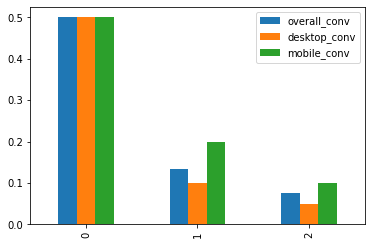

In [ ]:
device_rate_table.plot.bar();

Double check that there is a significant difference between mobile and desktop users like we suspected.

In [ ]:
ttest_ind(user_df[user_df['device'] == 'Desktop']['conf_page'],
          user_df[user_df['device'] == 'Mobile']['conf_page'])

Ttest_indResult(statistic=-15.114932029234419, pvalue=1.493037980910914e-51)

Now we look at the conversion rate for `sex`. The difference between male and female users seems to be minor.

In [ ]:
sex_rate_table = calculate_conversion_rates(user_df, 'overall_conv')

sex_rate_table = sex_rate_table.merge(calculate_conversion_rates(
                       user_df[user_df['sex'] == 'Male'], 'male_conv'))
sex_rate_table = sex_rate_table.merge(calculate_conversion_rates(
                       user_df[user_df['sex'] == 'Female'], 'female_conv'))
sex_rate_table

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,page,overall_conv,male_conv,female_conv
0,home,0.500000,0.496944,0.503073
1,search,0.133407,0.130083,0.136708
2,payment,0.074959,0.072014,0.077742


In [ ]:
user_df.groupby('sex')['conf_page'].sum()

sex
Female    241
Male      211
Name: conf_page, dtype: int64

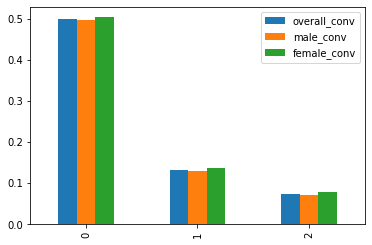

In [ ]:
sex_rate_table.plot.bar();

Once again confirming our suspicions, no real difference between the sexes.

In [ ]:
ttest_ind(user_df[user_df['sex'] == 'Male']['conf_page'],
          user_df[user_df['sex'] == 'Female']['conf_page'])

Ttest_indResult(statistic=-1.473571917457817, pvalue=0.14060036909365287)

Finally, lets take a look at the various combinations. We see what one might expect, the differences above persist and add to each other. Simply correcting the desktop experience would correct most of these differences.

In [ ]:
conv_rate_table = calculate_conversion_rates(user_df, 'overall_conv')

conv_rate_table = conv_rate_table.merge(calculate_conversion_rates(
                       user_df[(user_df['device'] == 'Desktop') &
                              (user_df['sex'] == 'Male')], 'desktop_m_conv'))
conv_rate_table = conv_rate_table.merge(calculate_conversion_rates(
                       user_df[(user_df['device'] == 'Desktop') &
                              (user_df['sex'] == 'Female')], 'desktop_f_conv'))
conv_rate_table = conv_rate_table.merge(calculate_conversion_rates(
                       user_df[(user_df['device'] == 'Mobile') &
                              (user_df['sex'] == 'Male')], 'mobile_m_conv'))
conv_rate_table = conv_rate_table.merge(calculate_conversion_rates(
                       user_df[(user_df['device'] == 'Mobile') &
                              (user_df['sex'] == 'Female')], 'mobile_f_conv'))

conv_rate_table

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,page,overall_conv,desktop_m_conv,desktop_f_conv,mobile_m_conv,mobile_f_conv
0,home,0.500000,0.496937,0.503084,0.496958,0.503051
1,search,0.133407,0.098608,0.101385,0.192947,0.206987
2,payment,0.074959,0.051351,0.048366,0.093103,0.106369


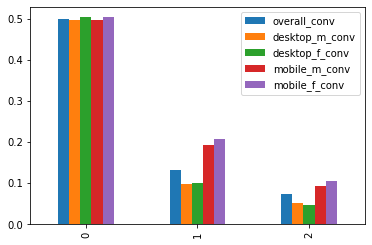

In [ ]:
conv_rate_table.plot.bar();

## Date

Last on the list of variables to check is conversion rate by date. Surprisingly we see a drop in the site's conversion rate starting in March. This could be a seasonality thing, but likely not since we were asked to look into this problem.

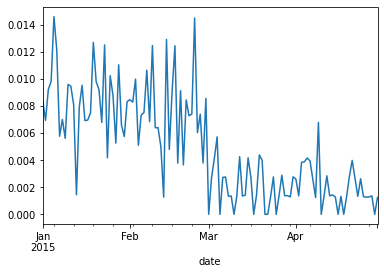

In [ ]:
user_df.groupby('date')['conf_page'].mean().plot();

Taking a look at total users each day we see a different trend. The total users jumped in February and then returned to normal levels. The return to normal levels coincides with the drop in conversion rate.

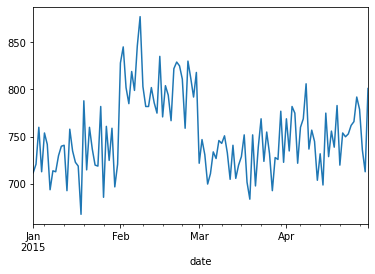

In [ ]:
user_df.groupby('date')['home_page'].count().plot();

Breaking out by device, we see the same drop in March with both Desktop and Mobile users.

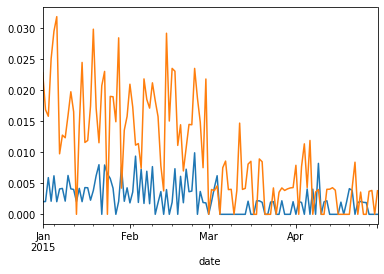

In [ ]:
user_df[user_df['device'] == 'Desktop'].groupby('date')['conf_page'].mean().plot();
user_df[user_df['device'] == 'Mobile'].groupby('date')['conf_page'].mean().plot();

Break out the data based on before and after the drop to better understand how big of an impact the March drop was. Right away we see that overall, the drop was from a conversion rate of .8% to .2%. Pretty impactful when the conversion rate was already weak to begin with.

In [ ]:
jan_feb = user_df[user_df['date'] < np.datetime64('2015-03-01')]
mar_apr = user_df[user_df['date'] >= np.datetime64('2015-03-01')]

print('January to March Conversion:', jan_feb['conf_page'].mean() * 100)
print('March to End Conversion:', mar_apr['conf_page'].mean() * 100)

January to March Conversion: 0.8008849557522124
March to End Conversion: 0.19911504424778761


In [ ]:
print('Total Sales by Period')
print('===============================')
print('January and February:', jan_feb['conf_page'].sum())
print('March and April:', mar_apr['conf_page'].sum())
print('Total:', user_df['conf_page'].sum())

Total Sales by Period
January and February: 362
March and April: 90
Total: 452


Mobile conversions crashed from 1.6% down to .35% after March. Desktop conversions took a dip too, but without much room to drop it only moved from .37% to .12%.

In [ ]:
print('Jan-March Conversion Rates')
print('================================')
print('Desktop:', jan_feb[jan_feb['device'] == 'Desktop']['conf_page'].mean() * 100)
print('Mobile:', jan_feb[jan_feb['device'] == 'Mobile']['conf_page'].mean() * 100)

Jan-March Conversion Rates
Desktop: 0.37873754152823924
Mobile: 1.642384105960265


In [ ]:
print('March-End Conversion Rates')
print('================================')
print('Desktop:', mar_apr[mar_apr['device'] == 'Desktop']['conf_page'].mean() * 100)
print('Mobile:', mar_apr[mar_apr['device'] == 'Mobile']['conf_page'].mean() * 100)

March-End Conversion Rates
Desktop: 0.11960132890365448
Mobile: 0.3576158940397351


It looks like both sexes saw a similar dip after March.

In [ ]:
print('Jan-March Conversion Rates')
print('================================')
print('Male:', jan_feb[jan_feb['sex'] == 'Male']['conf_page'].mean() * 100)
print('Female:', jan_feb[jan_feb['sex'] == 'Female']['conf_page'].mean() * 100)

Jan-March Conversion Rates
Male: 0.7393633505999025
Female: 0.8623358245257152


In [ ]:
print('March-End Conversion Rates')
print('================================')
print('Male:', mar_apr[mar_apr['sex'] == 'Male']['conf_page'].mean() * 100)
print('Female:', mar_apr[mar_apr['sex'] == 'Female']['conf_page'].mean() * 100)

March-End Conversion Rates
Male: 0.19350866391063418
Female: 0.20479031252782476


The funnel took a hit to the home page (Conversion rate drop of 20%) and the search page (drop of 11%). Payment to confirmation page seems unaffected by the drop at the start of March.

In [ ]:
conv_table_by_date = calculate_conversion_rates(user_df, 'overall')
conv_table_by_date = conv_table_by_date.merge(calculate_conversion_rates(jan_feb, 'jan_feb'))
conv_table_by_date = conv_table_by_date.merge(calculate_conversion_rates(mar_apr, 'mar_apr'))

conv_table_by_date

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,page,overall,jan_feb,mar_apr
0,home,0.500000,0.602677,0.397323
1,search,0.133407,0.176278,0.068378
2,payment,0.074959,0.075385,0.073290


# Conclusions

Looking at the data, we have two major points of concern that need to be addressed.

First, it appears the site underwent some change in February which led to a drop in the site's conversion rate by the start of March. This change led to an increase in visitors to the site's homepage that also dropped off in March.

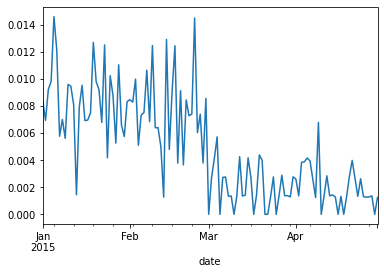

In [ ]:
user_df.groupby('date')['conf_page'].mean().plot();

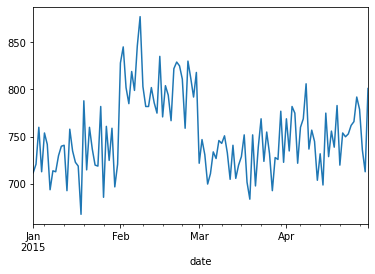

In [ ]:
user_df.groupby('date')['home_page'].count().plot();

We see the drop in site conversions is mostly the result of a 20% loss in the home page's conversion rate and a similar drop of 11% for the search page.

In [ ]:
conv_table_by_date

,page,overall,jan_feb,mar_apr
0,home,0.500000,0.602677,0.397323
1,search,0.133407,0.176278,0.068378
2,payment,0.074959,0.075385,0.073290


The graphs paired with each page's conversion rates before and after the start of March leads to the conclusion that changes were made to the Home page and possibly the Search page. These changes should be reverted immediately due to the fact that 80% of the sales in this 4 month period occured in the 2 months prior to the change.

Next is that the conversion rate for desktop users is significantly lower than that of mobile users. This should be another significant concern as two-thirds of visitors to the site are desktop. The product team should rework the desktop experience to increase the conversion rate so it is comprable to mobile. Worth noting, the problem with desktop vs mobile conversion rates holds for the entire four months indicating this is separate issue to address.

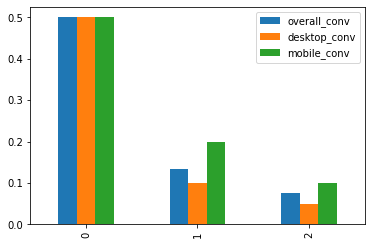

In [ ]:
device_rate_table.plot.bar();